In [87]:

import sys
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure


from pal.paldata import PalData
from pal.palmodel import PalModel

In [88]:
datasets = {"m2n4": [54000, 5900], # num train, test samples
        "m2n5" : [960000, 11830],
        "m2n6" : [300000,4990],
        "m2n7" : [120000, 5315]}

In [89]:
def paldata(m,n):
    
    print("preparing dataset...")
    pd = PalData(numProc=m, numTasks=n)

    pd.load_numpy_fromfile("data/paldata_m{}_n{}_ts_preproc.npy".format(m, n), 
                            "data/paldata_m{}_n{}_tl_preproc.npy".format(m, n)) 

    
    ds = datasets["m{}n{}".format(m, n)]
    X, Y = pd.next_batch(ds[0])
    X_test, Y_test = pd.next_batch(ds[1])
    
    return X,Y,X_test, Y_test

def paleval(m,n, X_test, Y_test):

    palmodel = PalModel(numProcs=m, numTasks=n, nb_epochs=60, leanring_rate=0.01)
    palmodel.load_model()

    accuracy, _, Y_test_hat_scheduable = palmodel.eval(X_test, Y_test)
    
    return accuracy, Y_test_hat_scheduable, palmodel

In [90]:
m=2
Xs = []
Ys = []
X_tests = []
Y_tests = []
num_Y_test_hat_samples = []
test_accs = []
train_accs = []

for n in [ 4,5,6,7 ]:
    print("----> Evaluate m{}n{} dataset".format(m,n))

    X, Y, X_test, Y_test = paldata(m,n)
    Xs.append(X)
    Ys.append(Y)
    X_tests.append(X_test)
    Y_tests.append(Y_test)

    print("---> Evaluate on training set")    
    acc, _, _ = paleval(m,n, X, Y)
    train_accs.append(acc)
    
    print("---> Evaluate on test set")
    acc, Y_test_hat_scheduable, _= paleval(m,n, X_test, Y_test)
    test_accs.append(acc)
    num_Y_test_hat_samples.append(np.sum(Y_test_hat_scheduable))

----> Evaluate m2n4 dataset
preparing dataset...
Load #515910 tasksets from data/paldata_m2_n4_ts_preproc.npy and #515910 tasks from file data/paldata_m2_n4_tl_preproc.npy
Acquired 54000 samples
Acquired 5900 samples
---> Evaluate on training set
Building PAL model...
Model: "model_82"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 4, 2)]       0                                            
__________________________________________________________________________________________________
encoder (LSTM)                  [(None, 4, 512), (No 1054720     main_input[0][0]                 
__________________________________________________________________________________________________
decoder (PointerLSTM)           (None, 4, None)      2624000     encoder[0][0]                    
                    

In [91]:
print("Train acc:", train_accs)
print("Test acc:", test_accs)
num_X_samples = [ len(Xs[i-4]) for i in [4,5,6,7]]
num_X_test_samples = [ len(X_tests[i-4]) for i in [4,5,6,7]]

print("num_X_samples: ", num_X_samples)
print("num_X_test_samples: ", num_X_test_samples)
print("num_Y_test_hat_samples:", num_Y_test_hat_samples)

Train acc: [0.879462962962963, 0.7210958333333334, 0.87485, 0.9401]
Test acc: [0.6340677966101695, 0.6483516483516484, 0.6154308617234469, 0.5747883349012229]
num_X_samples:  [54000, 960000, 300000, 120000]
num_X_test_samples:  [5900, 11830, 4990, 5315]
num_Y_test_hat_samples: [3741, 7670, 3071, 3055]


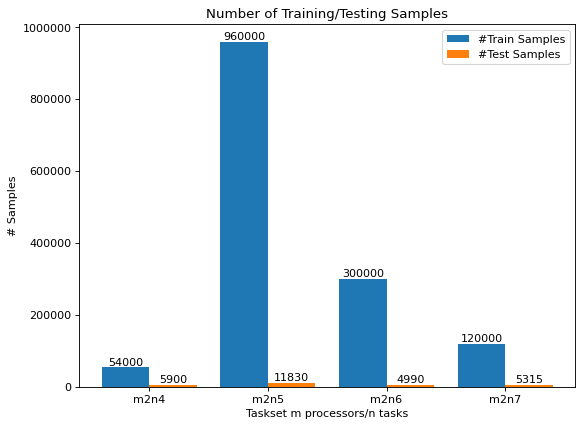

In [119]:

figure(figsize=(8, 6), dpi=80)

X_label = ["m{}n{}".format(2,n) for n in [4,5,6,7]]

x_axis = np.arange(len(X_label))

bar1 = plt.bar(x_axis - 0.2, num_X_samples, width=0.4,  label = '#Train Samples')
bar2 = plt.bar(x_axis + 0.2, num_X_test_samples, width=0.4, label = '#Test Samples')

for rect in [*bar1 , *bar2]:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')

plt.xticks(np.arange(len(X_label)), X_label)
#plt.ticklabel_format(axis="x", style="sci", scilimits=(0,10))
plt.ticklabel_format(axis="y", useOffset=False, style='plain')
plt.xlabel("Taskset m processors/n tasks")
plt.ylabel("# Samples")
plt.title("Number of Training/Testing Samples")
plt.legend()
plt.show()

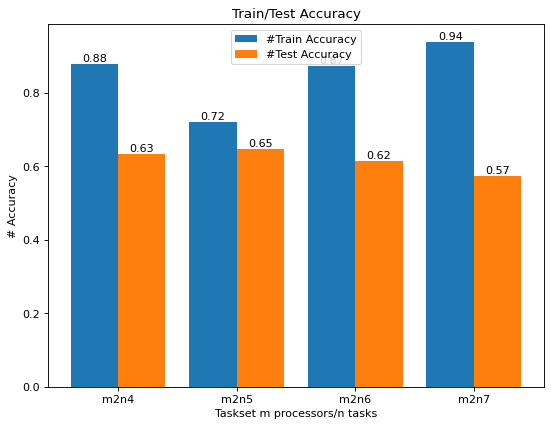

In [122]:
figure(figsize=(8, 6), dpi=80)

bar1 = plt.bar(x_axis - 0.2, train_accs, width=0.4,  label = '#Train Accuracy')
bar2 = plt.bar(x_axis + 0.2, test_accs, width=0.4, label = '#Test Accuracy')

for rect in [*bar1 , *bar2]:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom')


plt.xticks(np.arange(len(X_label)), X_label)
plt.xlabel("Taskset m processors/n tasks")
plt.ylabel("# Accuracy")
plt.title("Train/Test Accuracy")
plt.legend()
plt.show()

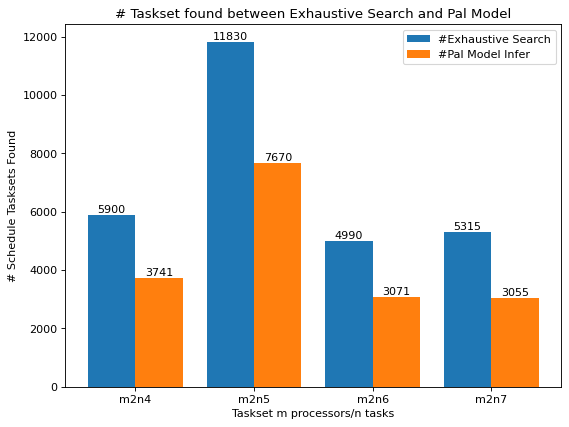

In [123]:
figure(figsize=(8, 6), dpi=80)


bar1=plt.bar(x_axis - 0.2, num_X_test_samples, width=0.4,  label = '#Exhaustive Search')
bar2=plt.bar(x_axis + 0.2, num_Y_test_hat_samples, width=0.4, label = '#Pal Model Infer')
for rect in [*bar1 , *bar2]:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % height, ha='center', va='bottom')

plt.xticks(np.arange(len(X_label)), X_label)
plt.xlabel("Taskset m processors/n tasks")
plt.ylabel("# Schedule Tasksets Found")
plt.title("# Taskset found between Exhaustive Search and Pal Model")
plt.legend()
plt.show()